In [16]:
!pip install gymnasium pygame torch numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [17]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [18]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x


In [19]:
class REINFORCE:
    def __init__(self, state_dim, action_dim, lr=0.01, gamma=0.99):
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)  # Adam Optimizer
        self.gamma = gamma
        self.log_probs = []
        self.rewards = []

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        probs = self.policy(state)
        distribution = torch.distributions.Categorical(probs)
        action = distribution.sample()
        self.log_probs.append(distribution.log_prob(action))
        return action.item()

    def update_policy(self):
        G = 0
        policy_loss = []
        for log_prob, reward in zip(reversed(self.log_probs), reversed(self.rewards)):
            G = reward + self.gamma * G
            policy_loss.append(-log_prob * G)

        self.optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum()
        loss.backward()
        self.optimizer.step()

        self.log_probs = []
        self.rewards = []

In [21]:
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, action_dim, lr=0.01)

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/

In [22]:
num_episodes = 500
reward_history = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        agent.rewards.append(reward)
        state = next_state
        total_reward += reward
        done = terminated or truncated

    agent.update_policy()
    reward_history.append(total_reward)

    if episode % 50 == 0:
        print(f"Episode {episode}: Total Reward = {total_reward}")


Episode 0: Total Reward = -59.09715872413068
Episode 50: Total Reward = -31.619373089341593
Episode 100: Total Reward = -131.24143236939196
Episode 150: Total Reward = -52.05323212688461
Episode 200: Total Reward = -37.60220417623964
Episode 250: Total Reward = -127.27304031378813
Episode 300: Total Reward = -150.65219651042358
Episode 350: Total Reward = -85.7504390181686
Episode 400: Total Reward = -147.04155884734632
Episode 450: Total Reward = -142.25195322121024


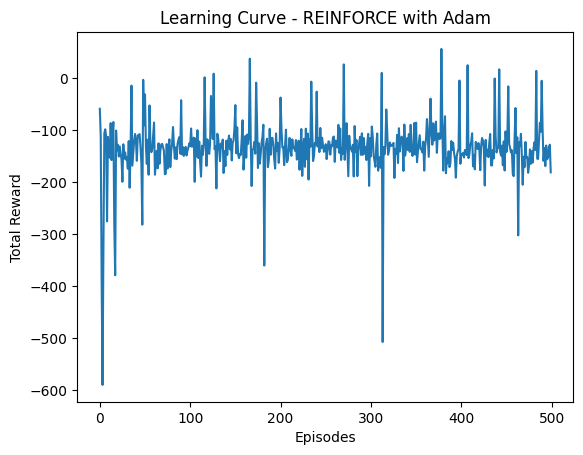

In [23]:
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Learning Curve - REINFORCE with Adam")
plt.show()


In [24]:
class REINFORCE:
    def __init__(self, state_dim, action_dim, lr=0.01, gamma=0.99):
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.SGD(self.policy.parameters(), lr=lr)  # SGD Optimizer
        self.gamma = gamma
        self.log_probs = []
        self.rewards = []

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        probs = self.policy(state)
        distribution = torch.distributions.Categorical(probs)
        action = distribution.sample()
        self.log_probs.append(distribution.log_prob(action))
        return action.item()

    def update_policy(self):
        G = 0
        policy_loss = []
        for log_prob, reward in zip(reversed(self.log_probs), reversed(self.rewards)):
            G = reward + self.gamma * G
            policy_loss.append(-log_prob * G)

        self.optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum()
        loss.backward()
        self.optimizer.step()

        self.log_probs = []
        self.rewards = []

In [25]:
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, action_dim, lr=0.01)

In [26]:
num_episodes = 500
reward_history = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        agent.rewards.append(reward)
        state = next_state
        total_reward += reward
        done = terminated or truncated

    agent.update_policy()
    reward_history.append(total_reward)

    if episode % 50 == 0:
        print(f"Episode {episode}: Total Reward = {total_reward}")

Episode 0: Total Reward = -58.86022704985236
Episode 50: Total Reward = -156.98947630087716
Episode 100: Total Reward = -129.9847768297446
Episode 150: Total Reward = -154.14455286453654
Episode 200: Total Reward = -94.40392542447455
Episode 250: Total Reward = -183.3697867645355
Episode 300: Total Reward = -149.99520242852097
Episode 350: Total Reward = -101.91450038760377
Episode 400: Total Reward = -136.6974299844798
Episode 450: Total Reward = -117.96750640554635


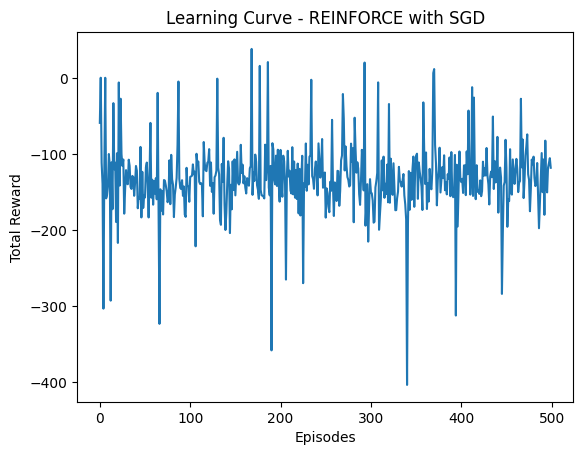

In [27]:
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Learning Curve - REINFORCE with SGD")
plt.show()

In [30]:
class REINFORCE:
    def __init__(self, state_dim, action_dim, lr=0.01, gamma=0.99):
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.RMSprop(self.policy.parameters(), lr=lr)  #rmsprop Optimizer
        self.gamma = gamma
        self.log_probs = []
        self.rewards = []

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        probs = self.policy(state)
        distribution = torch.distributions.Categorical(probs)
        action = distribution.sample()
        self.log_probs.append(distribution.log_prob(action))
        return action.item()

    def update_policy(self):
        G = 0
        policy_loss = []
        for log_prob, reward in zip(reversed(self.log_probs), reversed(self.rewards)):
            G = reward + self.gamma * G
            policy_loss.append(-log_prob * G)

        self.optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum()
        loss.backward()
        self.optimizer.step()

        self.log_probs = []
        self.rewards = []

In [31]:
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, action_dim, lr=0.01)

In [32]:
num_episodes = 500
reward_history = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        agent.rewards.append(reward)
        state = next_state
        total_reward += reward
        done = terminated or truncated

    agent.update_policy()
    reward_history.append(total_reward)

    if episode % 50 == 0:
        print(f"Episode {episode}: Total Reward = {total_reward}")

Episode 0: Total Reward = -331.0623079870519
Episode 50: Total Reward = -170.7577177103463
Episode 100: Total Reward = -131.0321311268373
Episode 150: Total Reward = -155.65724541371242
Episode 200: Total Reward = -166.16997882090544
Episode 250: Total Reward = -161.31593950484915
Episode 300: Total Reward = -80.91938967250744
Episode 350: Total Reward = -100.78689454153655
Episode 400: Total Reward = -134.27354729326618
Episode 450: Total Reward = -140.04323317480424


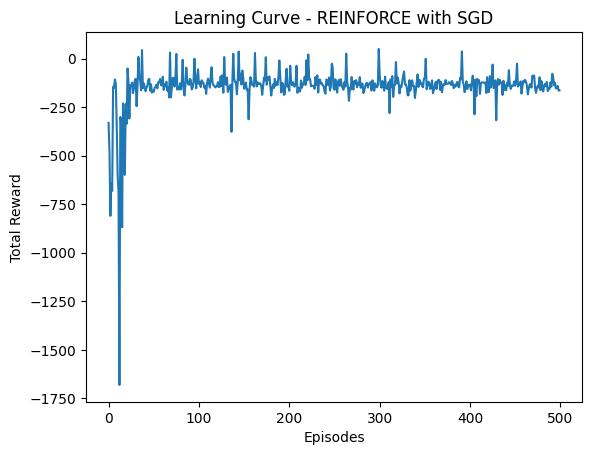

In [33]:
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Learning Curve - REINFORCE with SGD")
plt.show()